In [4]:
%matplotlib widget

Config loaded.
  Date range: 2021-01-01 -> 2024-01-01
  POOL_SIZE: 500
  N_ASSETS: 50
  N_PLOTS: 400
  WINDOW_SIZE: 60
  ALPHA: 0.6
  MIN_COVERAGE: 0.95
  RANDOM_SEED: 42



[*********************100%***********************]  500 of 500 completed

7 Failed downloads:
['PKI.TO', 'FI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2021-01-01 -> 2024-01-01) (Yahoo error = "No data found, symbol may be delisted")')
['WBA', 'AZPN', 'HES', 'BKW.AX', 'JNPR']: YFTzMissingError('possibly delisted; no timezone found')


Kept 451 / 500 tickers with >= 95% coverage
Dropped 207 days with missing data; 574 days remain
✅ Retrieved 451 assets over 574 days

returns_pool info:
  shape: (574, 451)
  n assets: 451
  first date: 2021-01-05 | last date: 2023-12-29

Universes sampled:
  Universe 1: 50 assets
  Universe 2: 50 assets
  Universe 3: 50 assets
  Universe 4: 50 assets
  Universe 5: 50 assets
  Universe 6: 50 assets
  Universe 7: 50 assets
  Universe 8: 50 assets
  Universe 9: 50 assets
  Universe 10: 50 assets
  Universe 11: 50 assets
  Universe 12: 50 assets
  Universe 13: 50 assets
  Universe 14: 50 assets
  Universe 15: 50 assets
  Universe 16: 50 assets
  Universe 17: 50 assets
  Universe 18: 50 assets
  Universe 19: 50 assets
  Universe 20: 50 assets
  Universe 21: 50 assets
  Universe 22: 50 assets
  Universe 23: 50 assets
  Universe 24: 50 assets
  Universe 25: 50 assets
  Universe 26: 50 assets
  Universe 27: 50 assets
  Universe 28: 50 assets
  Universe 29: 50 assets
  Universe 30: 50 assets
 

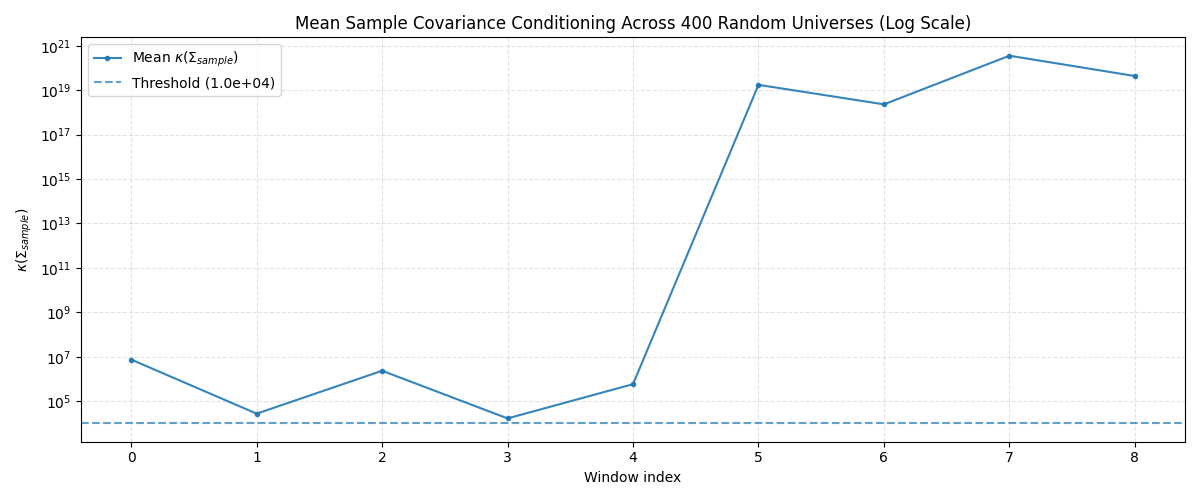

Figure A generated: MEAN κ(Σ_sample) across universes.


In [ ]:
# ============================================================
# EXPERIMENT:
# (A) Condition number ONLY of Sample Covariance κ(Σ_sample)
# (B) Temporal stability ONLY on Precision matrices Θ (Sample vs Glasso)
#      using normalized Frobenius differences across contiguous windows
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning
import warnings

from utility import get_data, glasso

# Optional: silence convergence warnings (Graphical Lasso)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# ============================================================
# 1) CONFIG
# ============================================================
START_DATE = "2021-01-01"
END_DATE   = "2024-01-01"

POOL_SIZE = 500                 # how many assets to download total
N_ASSETS  = 50                  # assets per universe
N_PLOTS   = 400                 # number of universes to show
PLOT_MEAN_ONLY = True   # plot mean across universes (True) or all universes (False)

ALPHA = 0.6
GLASSO_MAX_ITER = 300

WINDOW_WEEKS = 12
TRADING_DAYS_PER_WEEK = 5
WINDOW_SIZE = WINDOW_WEEKS * TRADING_DAYS_PER_WEEK

MAX_CONDITION_NUMBER = 1e4      # threshold line ONLY for κ(Σ_sample)
MIN_COVERAGE = 0.95

RANDOM_SEED = 42
rng = np.random.RandomState(RANDOM_SEED)


print("Config loaded.")
print("  Date range:", START_DATE, "->", END_DATE)
print("  POOL_SIZE:", POOL_SIZE)
print("  N_ASSETS:", N_ASSETS)
print("  N_PLOTS:", N_PLOTS)
print("  WINDOW_SIZE:", WINDOW_SIZE)
print("  ALPHA:", ALPHA)
print("  MIN_COVERAGE:", MIN_COVERAGE)
print("  RANDOM_SEED:", RANDOM_SEED)


# ============================================================
# 2) LOAD TICKERS + DOWNLOAD RETURNS POOL
# ============================================================
ALL_TICKERS = pd.read_csv("tickers_names.csv")["Ticker"].tolist()

if POOL_SIZE > len(ALL_TICKERS):
    raise ValueError(f"POOL_SIZE={POOL_SIZE} > number of tickers in CSV ({len(ALL_TICKERS)})")

pool_idx = rng.permutation(len(ALL_TICKERS))[:POOL_SIZE]
POOL_TICKERS = [ALL_TICKERS[i] for i in pool_idx]

print("\nDownloading returns for pool (one-shot)...")
returns_pool = get_data(
    POOL_TICKERS,
    START_DATE,
    END_DATE,
    min_coverage=MIN_COVERAGE,
    fill_nan=False,
    save=False
)

print("\nreturns_pool info:")
print("  shape:", returns_pool.shape)
print("  n assets:", returns_pool.shape[1])
print("  first date:", returns_pool.index[0].date(), "| last date:", returns_pool.index[-1].date())


# ============================================================
# 3) HELPERS
# ============================================================
def split_into_windows(returns_df, window_size):
    n_samples = returns_df.shape[0]
    n_windows = n_samples // window_size
    windows = []
    for i in range(n_windows):
        start = i * window_size
        end = start + window_size
        windows.append(returns_df.iloc[start:end])
    return windows

def frobenius_differences(mat_list, eps=1e-12):
    """
    Normalized Frobenius differences across consecutive windows:
        ||A_{t+1} - A_t||_F / ||A_t||_F
    """
    diffs = []
    for i in range(len(mat_list) - 1):
        A = mat_list[i]
        B = mat_list[i + 1]
        num = np.linalg.norm(B - A, ord="fro")
        den = np.linalg.norm(A, ord="fro")
        diffs.append(float(num / max(den, eps)))
    return np.array(diffs)

def compute_sample_covariance(window_returns):
    """
    Sample covariance computed the same way as in your original code:
    standardize -> cov -> rescale back.
    """
    scaler = StandardScaler()
    X = scaler.fit_transform(window_returns.values)

    cov_std = np.cov(X, rowvar=False)
    s = scaler.scale_
    D = np.diag(s)

    cov = D @ cov_std @ D
    return cov

def compute_condition_numbers_sample_cov(returns_universe, window_size):
    """
    κ(Σ_sample) per window (ONLY sample covariance).
    """
    windows = split_into_windows(returns_universe, window_size)
    conds = []
    for win in windows:
        cov = compute_sample_covariance(win)
        try:
            conds.append(float(np.linalg.cond(cov)))
        except np.linalg.LinAlgError:
            conds.append(float(np.inf))
    return np.array(conds), len(windows)

def compute_precision_lists_sample_and_glasso(returns_universe, alpha, window_size, max_iter):
    """
    For temporal stability:
    build lists of Θ (precision matrices) per window:
      - sample precision: pinv(Σ_sample)
      - glasso precision: Θ_glasso from Graphical Lasso
    """
    windows = split_into_windows(returns_universe, window_size)

    sample_precs = []
    glasso_precs = []

    for win in windows:
        # --- Sample precision ---
        sample_cov = compute_sample_covariance(win)
        sample_prec = np.linalg.pinv(sample_cov)  # robust
        sample_precs.append(sample_prec)

        # --- Glasso precision ---
        g_cov, g_prec = glasso(alpha=alpha, returns_df=win, save_outputs=False, max_iter=max_iter)
        glasso_precs.append(g_prec)

    return sample_precs, glasso_precs, len(windows)


# ============================================================
# 4) SAMPLE UNIVERSI
# ============================================================
available_tickers = list(returns_pool.columns)

if len(available_tickers) < N_ASSETS:
    raise ValueError(f"Not enough tickers in returns_pool ({len(available_tickers)}) for N_ASSETS={N_ASSETS}")

universes = []
for i in range(N_PLOTS):
    tickers_i = rng.choice(available_tickers, size=N_ASSETS, replace=False)
    universes.append(tickers_i)

print("\nUniverses sampled:")
for i, u in enumerate(universes):
    print(f"  Universe {i+1}: {len(u)} assets")


# ============================================================
# 5) FIGURE A — κ(Σ_sample) ONLY
# Option:
#   - plot all universes (grid)
#   - OR plot mean across universes (single plot)
# ============================================================

# Compute cond numbers for all universes first (so we can average if needed)
cond_sample_list = []
n_windows_list = []

for i, tickers_i in enumerate(universes):
    universe_df = returns_pool[list(tickers_i)].copy().dropna(axis=1, how="any")
    cond_sample, n_windows = compute_condition_numbers_sample_cov(universe_df, WINDOW_SIZE)
    cond_sample_list.append(cond_sample)
    n_windows_list.append(n_windows)

# sanity: ensure same number of windows across universes
if len(set(n_windows_list)) != 1:
    raise RuntimeError(
        f"Universes have different n_windows: {n_windows_list}. "
        "Cannot compute mean curve safely."
    )

n_windows = n_windows_list[0]
x = np.arange(n_windows)

if PLOT_MEAN_ONLY:
    # -----------------------------
    # SINGLE PLOT: mean across universes
    # -----------------------------
    M = np.vstack(cond_sample_list)  # shape: (N_PLOTS, n_windows)
    mean_cond = np.mean(M, axis=0)

    plt.figure(figsize=(12, 5))
    plt.plot(x, mean_cond, marker=".", linestyle="-", alpha=0.9, label=r"Mean $\kappa(\Sigma_{sample})$")
    plt.axhline(MAX_CONDITION_NUMBER, linestyle="--", alpha=0.7, label=f"Threshold ({MAX_CONDITION_NUMBER:.1e})")

    plt.yscale("log")
    plt.title(f"Mean Sample Covariance Conditioning Across {N_PLOTS} Random Universes (Log Scale)")
    plt.xlabel("Window index")
    plt.ylabel(r"$\kappa(\Sigma_{sample})$")
    plt.grid(True, which="both", ls="--", alpha=0.35)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("Figure A generated: MEAN κ(Σ_sample) across universes.")

else:
    # -----------------------------
    # GRID PLOT: all universes
    # -----------------------------
    ncols = 2
    nrows = int(np.ceil(N_PLOTS / ncols))

    figA, axesA = plt.subplots(nrows, ncols, figsize=(16, 3.6 * nrows))
    axesA = np.array(axesA).flatten()

    for i in range(N_PLOTS):
        ax = axesA[i]
        cond_sample = cond_sample_list[i]

        ax.plot(x, cond_sample, marker=".", linestyle="-", alpha=0.85, label=r"$\kappa(\Sigma_{sample})$")
        ax.axhline(MAX_CONDITION_NUMBER, linestyle="--", alpha=0.7, label=f"Threshold ({MAX_CONDITION_NUMBER:.1e})")

        ax.set_yscale("log")
        ax.set_title(f"Universe {i+1} (N={N_ASSETS}, {n_windows} windows)")
        ax.set_xlabel("Window index")
        ax.set_ylabel(r"$\kappa(\Sigma_{sample})$")
        ax.grid(True, which="both", ls="--", alpha=0.35)

    # turn off unused axes if any
    for j in range(N_PLOTS, len(axesA)):
        axesA[j].axis("off")

    # Global legend (clean)
    handles, labels = axesA[0].get_legend_handles_labels()
    figA.legend(handles, labels, loc="upper center", ncol=2, frameon=False, bbox_to_anchor=(0.5, 1.02))

    figA.suptitle("Sample Covariance Conditioning Across Random Universes", y=1.06, fontsize=14)
    plt.tight_layout()
    plt.show()

    print("Figure A generated: κ(Σ_sample) for each universe.")




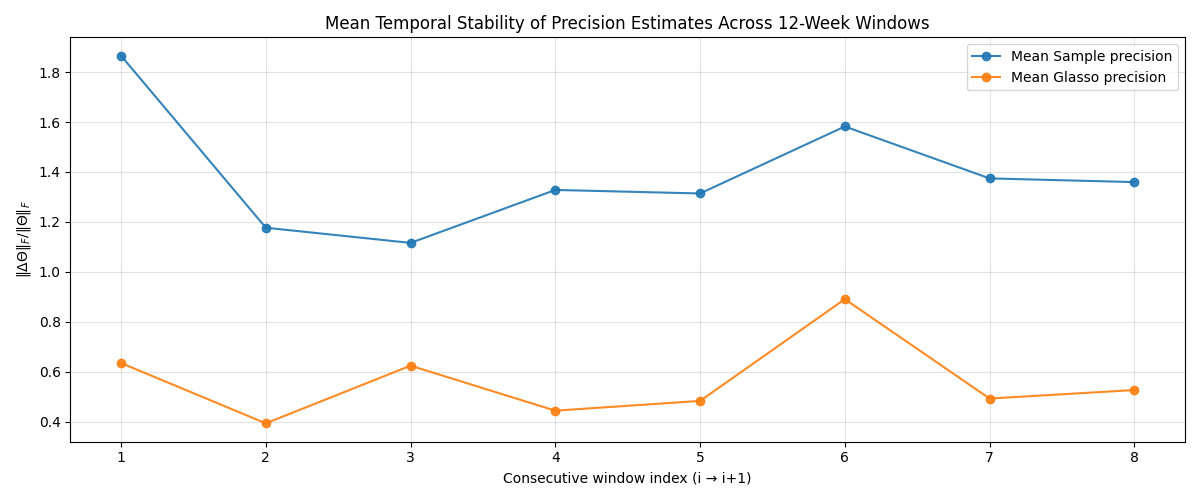

Figure B generated: MEAN precision stability across universes.

Stability statistic on precision (mean of ||ΔΘ||/||Θ|| across all 400 universes & windows):
Sample precision: 1.3895090801274153
Glasso precision: 0.5614256238950588


In [6]:
# ============================================================
# FIGURE B — Temporal stability on PRECISION ONLY (ΔΘ)
# Option:
#   - plot all universes (grid)
#   - OR plot mean across universes (single plot)
# Also compute ONE stability statistic per estimator (2 numbers)
# ============================================================

fro_sample_list = []
fro_glasso_list = []
n_pairs_list = []

# --- collect stability series for all universes first ---
for i, tickers_i in enumerate(universes):
    universe_df = returns_pool[list(tickers_i)].copy().dropna(axis=1, how="any")

    sample_precs, glasso_precs, n_windows = compute_precision_lists_sample_and_glasso(
        universe_df, alpha=ALPHA, window_size=WINDOW_SIZE, max_iter=GLASSO_MAX_ITER
    )

    fro_sample_prec = frobenius_differences(sample_precs)
    fro_glasso_prec = frobenius_differences(glasso_precs)

    fro_sample_list.append(fro_sample_prec)
    fro_glasso_list.append(fro_glasso_prec)
    n_pairs_list.append(len(fro_sample_prec))

# sanity: ensure same number of consecutive-window pairs across universes
if len(set(n_pairs_list)) != 1:
    raise RuntimeError(
        f"Universes have different number of window-pairs: {n_pairs_list}. "
        "Cannot compute mean stability curve safely."
    )

n_pairs = n_pairs_list[0]
x = np.arange(1, n_pairs + 1)

# ============================================================
# PLOTTING
# ============================================================
if PLOT_MEAN_ONLY:
    # -----------------------------
    # SINGLE PLOT: mean across universes
    # -----------------------------
    M_sample = np.vstack(fro_sample_list)   # shape: (N_PLOTS, n_pairs)
    M_glasso = np.vstack(fro_glasso_list)

    mean_sample = np.mean(M_sample, axis=0)
    mean_glasso = np.mean(M_glasso, axis=0)

    plt.figure(figsize=(12, 5))
    plt.plot(x, mean_sample, marker="o", linestyle="-", alpha=0.9, label="Mean Sample precision")
    plt.plot(x, mean_glasso, marker="o", linestyle="-", alpha=0.9, label="Mean Glasso precision")

    plt.title(f"Mean Temporal Stability of Precision Estimates Across {WINDOW_WEEKS}-Week Windows")
    plt.xlabel("Consecutive window index (i → i+1)")
    plt.ylabel(r"$\|\Delta\Theta\|_F / \|\Theta\|_F$")
    plt.grid(True, alpha=0.35)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("Figure B generated: MEAN precision stability across universes.")

else:
    # -----------------------------
    # GRID PLOT: all universes
    # -----------------------------
    ncols = 2
    nrows = int(np.ceil(N_PLOTS / ncols))

    figB, axesB = plt.subplots(nrows, ncols, figsize=(16, 3.6 * nrows))
    axesB = np.array(axesB).flatten()

    for i in range(N_PLOTS):
        ax = axesB[i]
        ax.plot(x, fro_sample_list[i], marker="o", linestyle="-", alpha=0.85, label="Sample precision")
        ax.plot(x, fro_glasso_list[i], marker="o", linestyle="-", alpha=0.85, label="Glasso precision")

        ax.set_title(f"Universe {i+1} — Precision stability (ΔΘ)")
        ax.set_xlabel("Consecutive window index (i → i+1)")
        ax.set_ylabel(r"$\|\Delta\Theta\|_F / \|\Theta\|_F$")
        ax.grid(True, alpha=0.35)

    # turn off unused axes if any
    for j in range(N_PLOTS, len(axesB)):
        axesB[j].axis("off")

    # Global legend
    handles, labels = axesB[0].get_legend_handles_labels()
    figB.legend(handles, labels, loc="upper center", ncol=2, frameon=False, bbox_to_anchor=(0.5, 1.02))

    figB.suptitle(f"Temporal Stability of Precision Estimates Across {WINDOW_WEEKS}-Week Windows", y=1.06, fontsize=14)
    plt.tight_layout()
    plt.show()

    print("Figure B generated: precision stability for each universe.")


# ============================================================
# FINAL: TWO NUMBERS (stability statistic)
# mean across all universes & all consecutive-window pairs
# ============================================================

all_fro_sample_prec = np.concatenate(fro_sample_list).astype(float)
all_fro_glasso_prec = np.concatenate(fro_glasso_list).astype(float)

stability_sample = float(np.mean(all_fro_sample_prec))   # or np.median(...)
stability_glasso = float(np.mean(all_fro_glasso_prec))

print(f"\nStability statistic on precision (mean of ||ΔΘ||/||Θ|| across all {N_PLOTS} universes & windows):")
print("Sample precision:", stability_sample)
print("Glasso precision:", stability_glasso)



=== OOS GMV experiment ===
Train: 2021-01-01 -> 2023-12-31
Test : 2024-01-01 -> 2024-12-31
N_ASSETS_OOS: 200
N_UNIVERSES_OOS: 20



[*********************100%***********************]  500 of 500 completed

7 Failed downloads:
['HES', 'WBA', 'AZPN', 'BKW.AX', 'JNPR']: YFTzMissingError('possibly delisted; no timezone found')
['PKI.TO', 'FI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2021-01-01 -> 2025-01-01) (Yahoo error = "No data found, symbol may be delisted")')


Kept 451 / 500 tickers with >= 95% coverage
Dropped 282 days with missing data; 761 days remain
✅ Retrieved 451 assets over 761 days
returns_oos_pool shape: (761, 451)
returns_oos_pool range: 2021-01-05 -> 2024-12-30

Universes successfully evaluated: 20
Glasso win-rate (final value > Sample): 100.0%


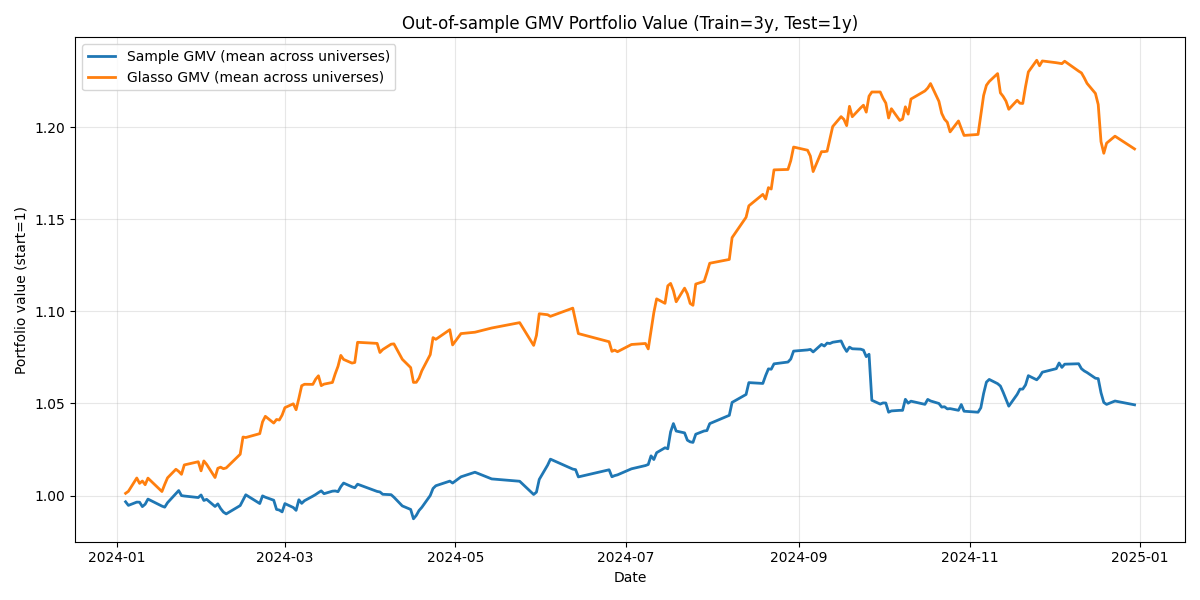

In [8]:
# ============================================================
# OOS GMV PERFORMANCE (3y train, 1y test) — Portfolio VALUE plot
# Compare Sample vs Glasso across MANY random universes
# Output: ONE plot (mean portfolio value across universes)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# OOS CONFIG
# -----------------------------
OOS_START_DATE = "2021-01-01"
OOS_END_DATE   = "2025-01-01"
TRAIN_YEARS = 3
TEST_YEARS  = 1

N_ASSETS_OOS = 200         
N_UNIVERSES_OOS = 20       

oos_start = pd.Timestamp(OOS_START_DATE)
oos_end   = pd.Timestamp(OOS_END_DATE)
train_end = oos_start + pd.DateOffset(years=TRAIN_YEARS)
test_end  = train_end + pd.DateOffset(years=TEST_YEARS)

if test_end > oos_end:
    raise ValueError("Not enough data for TRAIN_YEARS + TEST_YEARS inside the date range.")

print("\n=== OOS GMV experiment ===")
print("Train:", oos_start.date(), "->", (train_end - pd.Timedelta(days=1)).date())
print("Test :", train_end.date(), "->", (test_end - pd.Timedelta(days=1)).date())
print("N_ASSETS_OOS:", N_ASSETS_OOS)
print("N_UNIVERSES_OOS:", N_UNIVERSES_OOS)

# -----------------------------
# Download OOS pool ONCE
# -----------------------------
print("\nDownloading returns for OOS pool (one-shot)...")
returns_oos_pool = get_data(
    POOL_TICKERS,
    OOS_START_DATE,
    OOS_END_DATE,
    min_coverage=MIN_COVERAGE,
    fill_nan=False,
    save=False
)

returns_oos_pool = returns_oos_pool.loc[oos_start:oos_end].copy()

print("returns_oos_pool shape:", returns_oos_pool.shape)
print("returns_oos_pool range:", returns_oos_pool.index.min().date(), "->", returns_oos_pool.index.max().date())

# -----------------------------
# Sample OOS universes
# -----------------------------
available_tickers_oos = list(returns_oos_pool.columns)

if len(available_tickers_oos) < N_ASSETS_OOS:
    raise ValueError(f"Not enough tickers in returns_oos_pool ({len(available_tickers_oos)}) for N_ASSETS_OOS={N_ASSETS_OOS}")

universes_oos = []
for _ in range(N_UNIVERSES_OOS):
    tickers_i = rng.choice(available_tickers_oos, size=N_ASSETS_OOS, replace=False)
    universes_oos.append(list(tickers_i))

# -----------------------------
# GMV helper (precision-based)
# -----------------------------
def min_variance_portfolio(Theta):
    ones = np.ones(Theta.shape[0])
    A = ones @ Theta @ ones
    if (not np.isfinite(A)) or (A <= 0):
        raise ValueError("Invalid A = 1' Theta 1.")
    return (Theta @ ones) / A

# -----------------------------
# Run OOS across universes
# Store value series per universe (Sample & Glasso)
# -----------------------------
values_sample = []
values_glasso = []
final_wins = []  # 1 if glasso final > sample final

for u_idx, tickers_i in enumerate(universes_oos, start=1):
    df_u = returns_oos_pool[tickers_i].copy()

    # strict: remove assets with any NaNs
    df_u = df_u.dropna(axis=1, how="any")

    if df_u.shape[1] < max(5, int(0.7 * N_ASSETS_OOS)):
        print(f"OOS Universe {u_idx}: skipped (too few assets after NaN-drop: {df_u.shape[1]})")
        continue

    train_mask = (df_u.index >= oos_start) & (df_u.index < train_end)
    test_mask  = (df_u.index >= train_end) & (df_u.index < test_end)

    train_returns = df_u.loc[train_mask]
    test_returns  = df_u.loc[test_mask]

    if train_returns.empty or test_returns.empty:
        print(f"OOS Universe {u_idx}: skipped (empty train/test split)")
        continue

    # Sample precision (from sample covariance)
    sample_cov = train_returns.cov().values
    sample_prec = np.linalg.pinv(sample_cov)

    # Glasso precision
    glasso_cov, glasso_prec = glasso(
        alpha=ALPHA,
        returns_df=train_returns,
        save_outputs=False,
        max_iter=GLASSO_MAX_ITER
    )

    # GMV weights
    try:
        w_sample = min_variance_portfolio(sample_prec)
        w_glasso = min_variance_portfolio(glasso_prec)
    except Exception as e:
        print(f"OOS Universe {u_idx}: skipped (weight computation failed: {e})")
        continue

    w_sample = pd.Series(w_sample, index=train_returns.columns)
    w_glasso = pd.Series(w_glasso, index=train_returns.columns)

    # OOS daily returns
    test_returns = test_returns.loc[:, train_returns.columns]
    ret_sample = test_returns.values @ w_sample.values
    ret_glasso = test_returns.values @ w_glasso.values

    # Portfolio value series
    value_sample = pd.Series((1.0 + ret_sample).cumprod(), index=test_returns.index, name=f"Sample_{u_idx}")
    value_glasso = pd.Series((1.0 + ret_glasso).cumprod(), index=test_returns.index, name=f"Glasso_{u_idx}")

    values_sample.append(value_sample)
    values_glasso.append(value_glasso)

    final_wins.append(1 if value_glasso.iloc[-1] > value_sample.iloc[-1] else 0)

print("\nUniverses successfully evaluated:", len(values_sample))

if len(values_sample) == 0:
    raise RuntimeError("No successful universes. Reduce N_ASSETS_OOS, reduce MIN_COVERAGE, or check date range.")

# -----------------------------
# Aggregate into ONE curve (mean across universes)
# (align on common test dates)
# -----------------------------
V_sample = pd.concat(values_sample, axis=1)
V_glasso = pd.concat(values_glasso, axis=1)

# use mean across universes (could switch to median if you prefer)
mean_value_sample = V_sample.mean(axis=1)
mean_value_glasso = V_glasso.mean(axis=1)

# Win rate
win_rate = 100.0 * (np.mean(final_wins) if len(final_wins) > 0 else 0.0)
print(f"Glasso win-rate (final value > Sample): {win_rate:.1f}%")

# -----------------------------
# Plot: portfolio value over time (mean across universes)
# -----------------------------
plt.figure(figsize=(12, 6))
plt.plot(mean_value_sample.index, mean_value_sample.values, linewidth=2, label="Sample GMV (mean across universes)")
plt.plot(mean_value_glasso.index, mean_value_glasso.values, linewidth=2, label="Glasso GMV (mean across universes)")

plt.title("Out-of-sample GMV Portfolio Value (Train=3y, Test=1y)")
plt.xlabel("Date")
plt.ylabel("Portfolio value (start=1)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
